In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## VGG16 Model 구조도
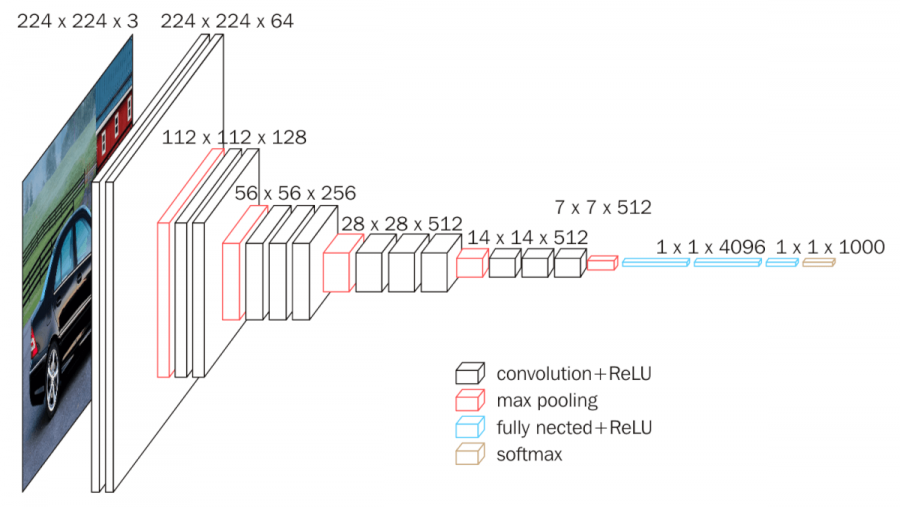

- 3x3 합성곱 연산 x2 (채널 64)  
- 3x3 합성곱 연산 x2 (채널 128)  
- 3x3 합성곱 연산 x3 (채널 256)  
- 3x3 합성곱 연산 x3 (채널 512)  
- 3x3 합성곱 연산 x3 (채널 512)  
- FC layer x3
  - FC layer 4096
  - FC layer 4096
  - FC layer 1000

# 1. Datasets 불러오기

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import torchvision

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [3]:
path2data = '/content/drive/MyDrive/모델 구현/data'

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

# CIFAR10 TRAIN 데이터 정의 32x32
#데이터 다운
cifar10_train = datasets.CIFAR10(path2data, train=True, transform=transform, target_transform=None, download=True)
#데이터를 불러옴
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size,
                                          shuffle=True) #num_workers 수 = 가용할 cpu 스레드 개수

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(path2data, train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 40194941.28it/s]


Extracting /content/drive/MyDrive/모델 구현/data/cifar-10-python.tar.gz to /content/drive/MyDrive/모델 구현/data
Files already downloaded and verified


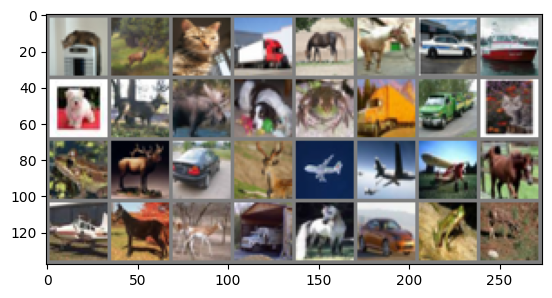

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    # unnormalize (시각화를 위해서)
    img = img / 2 + 0.5 #0~1 사이 형태에서 벗어나게 하기 위함??

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #이미지 차원 조절
    plt.show()

# 학습용 이미지를 무작위로 가져오기
images, labels = next(iter(train_loader))

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# 2. Define Arhitecture

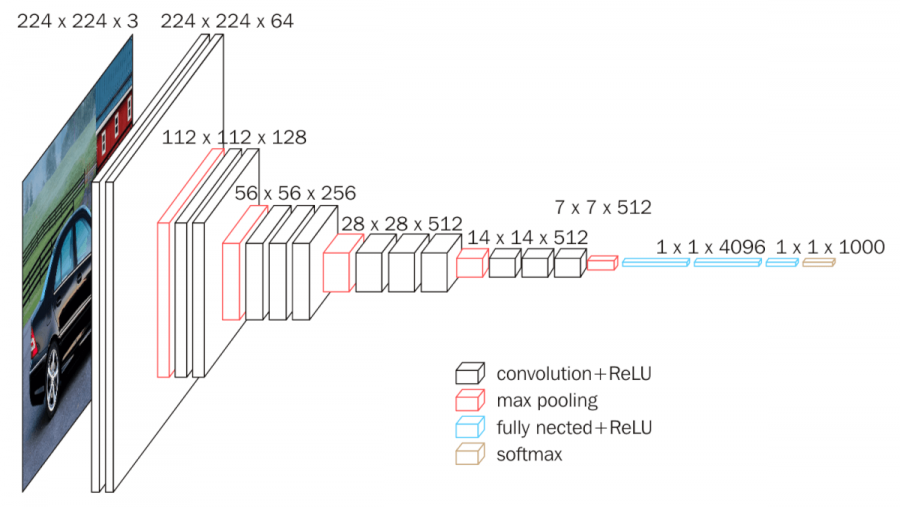

## 2-1) Block 정의

In [5]:
def conv_2_block(in_dim,out_dim):
  #Sequential이란?
  #nn.Linear, nn.ReLU(활성화 함수) 같은 모듈들을 인수로 받아서
  #순서대로 정렬해놓고 입력값이 들어모면 순서대로 모듈을 실행해서 결과값을 리턴

  #이미지
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, kernel_size = 3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim, out_dim, kernel_size = 3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
  )
  return model

  cat  deer   cat truck horse horse   car  ship   dog  deer  deer   dog  frog truck truck   cat  frog  deer   car  deer plane plane plane horse plane horse  deer truck horse   car  frog  deer


In [6]:
def conv_3_block(in_dim,out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
      #이미지 크기에 대한 값은 들어가지 않음
      #only 채널 수
      nn.ReLU(),
      nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
  )
  return model

## 2-2) VGG16 정의

In [18]:
#nn:신경망 계층(layer)과 거의 비슷한 Module 의 집합을 정의
#Module: 입력 텐서를 받고 출력 텐서를 계산
#nn.Module : 신경망 모델을 정의할 때 사용되는 기본 클래스 (레시피를 의미)

class VGG(nn.Module): #class VGG는 nn.Module을 상속함
  def __init__(self,base_dim,num_classes=10):
    super(VGG,self).__init__() #nn.Module의 생성자를 호출하여 초기화하는 역할
    #여기에서 VGG 클래스에 필요한 다양한 레이어들을 추가할 수 있음!

    #채널 수 관련
    self.feature = nn.Sequential(
        #base_dim = 64채널임
        conv_2_block(3,base_dim), #64채널
        conv_2_block(base_dim,2*base_dim), #64*2 = 128채널
        conv_3_block(2*base_dim,4*base_dim), #64*4 = 256채널
        conv_3_block(4*base_dim,8*base_dim), #64*8 = 512채널
        conv_3_block(8*base_dim, 8*base_dim) #64*8 = 512채널
    )

    #FC layer
    self.fc_layer = nn.Sequential(
        #flatten 시킨 것에 대한 값 계산
        nn.Linear(8*base_dim*1*1,4096), #512*1*1 <-> input : 224x224 -> 7*7*512
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096,1000),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(1000,num_classes) #다른 데이터셋이기 때문에, class 개수에 맞게 더 줄임
    )

  #이미지 x가 input으로 들어감
  def forward(self,x):
    x = self.feature(x)
    #print(x.shape)
    #print(x.size(0)) #첫번째 차원의 크기 (미니배치 크기) ?????????
    x = x.view(x.size(0),-1) #1차원으로 펼침(flatten) ?????????
    #print(x.shape)
    x = self.fc_layer(x)
    return x

## 2-3) Model, Loss, Optimizer 선언

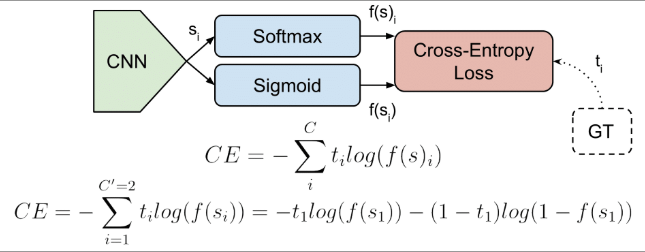

In [19]:
batch_size = 32
learning_rate = 0.001
num_epoch = 100

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = VGG(base_dim=64).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

# 3. Train & Test

In [21]:
# Train

loss_arr = []

for i in range(num_epoch):
  for j, [image,label] in enumerate(train_loader):
    x = image.to(device)
    y_ = label.to(device)

    optimizer.zero_grad() #초기화
    output = model.forward(x) #순전파
    loss = loss_func(output,y_) #loss_func
    loss.backward() #역전파
    optimizer.step() #가중치 업데이트

  if i%10 ==0: #loss 출력
    print(loss)
    #detach => requies_grad = False로 설정, gradient의 전파를 멈춤
    #https://iambeginnerdeveloper.tistory.com/211
    loss_arr.append(loss.cpu().detach().numpy()) #loss_arr에 추가

tensor(2.2915, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3053, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3054, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3030, device='cuda:0', grad_fn=<NllLossBackward0>)


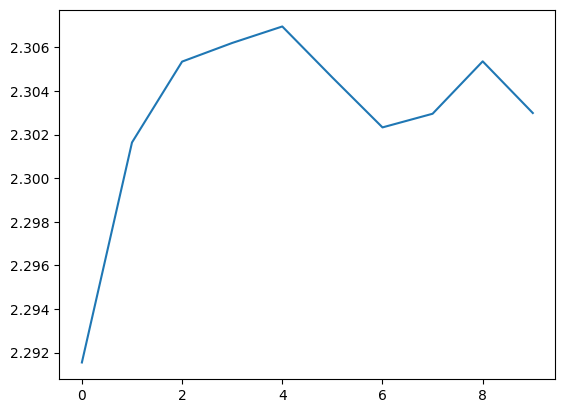

In [22]:
plt.plot(loss_arr)
#x축의 의미?
plt.show()

In [25]:
# test 결과

correct = 0
total = 0

model.eval() # 학습할 때만 필요했던 Dropout, Batchnorm등의 기능을 비활성화 해줌

with torch.no_grad(): #가중치 업데이트 x
  for image, label in test_loader:

    x = image.to(device)
    y = label.to(device)

    output = model.forward(x)
    #output의 크기는 (배치 크기) x (클래스의 개수)
    #ex) outputs = [[0.1, 0.4, 0.5], [0.2, 0.6, 0,2]] => 배치 크기 : 2, 클래스 : 3
    #torch.max는 최댓값과 최댓값의 위치를 반환하는데, 우리가 필요한 것은 최댓값 위치만 필요함
    #따라서, _로 처리해서 받지 않음 -> 최댓값의 위치(인덱스)만 total 에 저장
    #https://www.inflearn.com/questions/282058/%EB%AA%A8%EB%8D%B8-%ED%8F%89%EA%B0%80-%EB%B6%80%EB%B6%84-%EC%A7%88%EB%AC%B8%EB%93%9C%EB%A6%BD%EB%8B%88%EB%8B%A4
    _,output_index = torch.max(output,1)


    #전체 개수 -> 라벨의 개수
    #전체 개수를 알고 있음에도 이렇게 하는 이유 : batch_size, drop_last의 영향으로 몇몇 데이터가 잘린다?
    total += label.size(0) #개수 누적(총개수)
    #print(total) #테스트 이미지 개수


    correct += (output_index ==y).sum().float() #누적(맞으면 1, 틀리면 0으로 합산)
    #print(correct)

  print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 10.0%
